In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from decision import haversine
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance 
from sklearn.metrics import pairwise
from sklearn import metrics
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta, date
from sklearn import preprocessing
from sklearn.model_selection import KFold


from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xg

%matplotlib inline

In [3]:
data = pd.read_csv('1_250_full_data.csv',
                        index_col=0,
                        #usecols = ['POLYLINE', 'Destination'],
                        converters={'POLYLINE': lambda x: json.loads(x), 'Destination': lambda x: json.loads(x)})

In [8]:
def traj_score(targets, predicted):
    return np.mean(np.power([haversine(targets[i], predicted[i]) for i in xrange(len(targets))], 2))

def data_processing_to_train(data, get_dummies=True, y_in_list=True):
    #this data also can used for clustering (before creat dummies)
    
    # make y for predictions
    if y_in_list == True:
        y = list(np.array(data['Destination']))
    else:
        y = np.array(data['Destination'])
    
    # add start_lat and start_lon to the dataset
    traj = np.array(data['POLYLINE'])
    data['Start_lon'] = [i[0][0] for i in traj]
    data['Start_lat'] = [i[0][1] for i in traj]
    
    # fill NA values as specific class
    data = data.fillna('0')
    
    # make some columns categorical (str)
    cat_columns = ['CALL_TYPE','DAY_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID']
    data[cat_columns] = data[cat_columns].astype(str)
    
    # drop irrelevant columns
    data = data.drop(['Destination','MISSING_DATA', 'TRIP_ID', 'POLYLINE', 'DAY_TYPE'], 1)
    
    # next step is to work with timestamps
    
    # get list of holidays in Portugal
    pd_holidays = pd.read_csv('Portugal_holidays.csv')
    holidays = [date(pd_holidays.Year[i], pd_holidays.Month[i], pd_holidays.Day[i]) for i in range(len(pd_holidays))]
    del pd_holidays
    
    # get year, month, day, seconds from midnight, weeknumber, weekday

    dates = []
    for tmstmp in data['TIMESTAMP']:
        t = datetime.utcfromtimestamp(tmstmp)
        date_info = []
        date_info.append(t.year) # year
        date_info.append(t.month) # month
        date_info.append(t.isocalendar()[1]) # weeknumber
        date_info.append(t.weekday()) # weekday where Monday is 0 and Sunday is 6
        date_info.append((t.hour * 3600) + (t.minute * 60) + t.second + (t.microsecond / 1000000.0)) # seconds from midnight

        t_date = t.date()
        if t_date in holidays:
            date_info.append('B')
        elif (date_info[3] == 6) or (date_info[3] == 5):
            date_info.append('B')
        elif (t_date + timedelta(1)) in holidays:
            date_info.append('C')
        elif date_info[3] == 4:
            date_info.append('C')
        else:
            date_info.append('A')

        dates.append(date_info)

    dates = np.array(dates)
    dates_columns = ['YEAR', 'MONTH', 'WEEKNUM', 'WEEKDAY', 'SECFROMMID', 'DAY_TYPE']
    dates_df = pd.DataFrame(data = dates, columns = dates_columns)

    data = pd.concat([data, dates_df], axis=1)
    data['SECFROMMID'] = data['SECFROMMID'].astype(float)
    
    if get_dummies == True:
        dummy_cols = ['CALL_TYPE','DAY_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 
              'YEAR', 'MONTH', 'WEEKNUM', 'WEEKDAY']

        data = pd.get_dummies(data, columns=dummy_cols)

        drop_columns = ['CALL_TYPE_A', 'DAY_TYPE_A', 'ORIGIN_CALL_2002.0', 'ORIGIN_STAND_1.0', 'TAXI_ID_20000066.0',
                        'YEAR_2013', 'MONTH_1', 'WEEKNUM_1', 'WEEKDAY_0']
        data = data.drop(drop_columns,1)
        
        return data, y
    else:
        return data, y
         

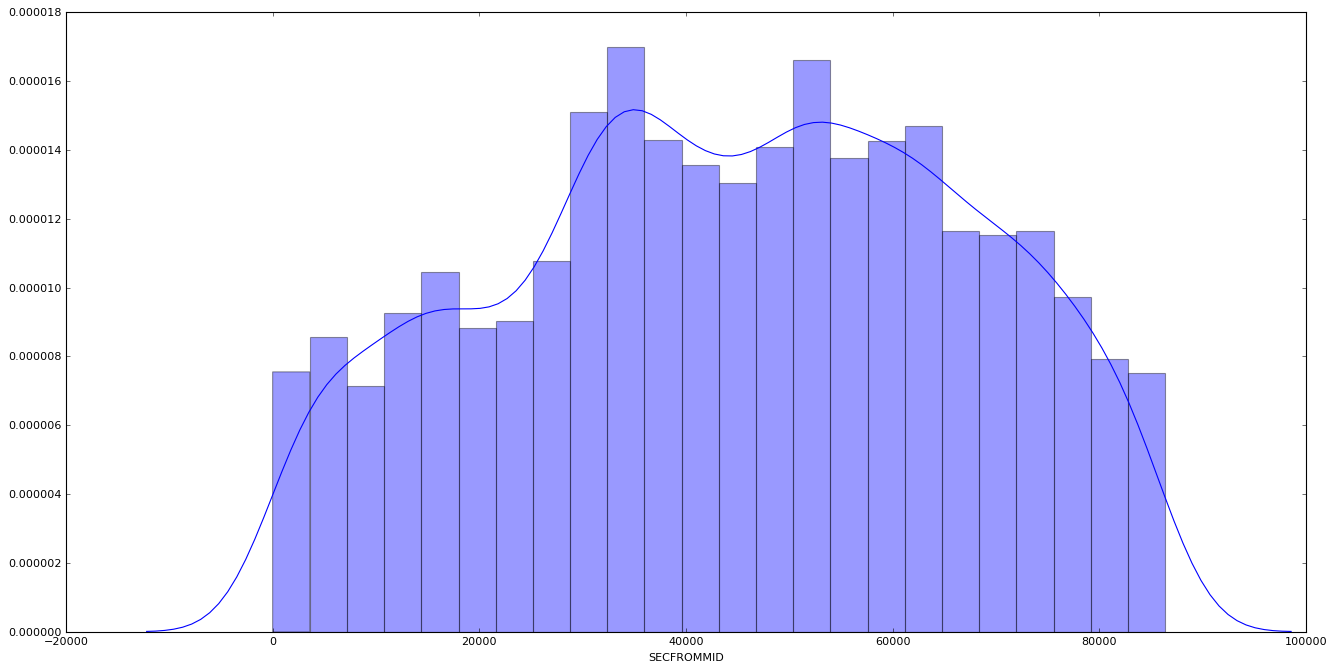

In [5]:
plt.figure(figsize=(20,10))
sns.distplot(data_to_cluster['SECFROMMID'], bins = 24);

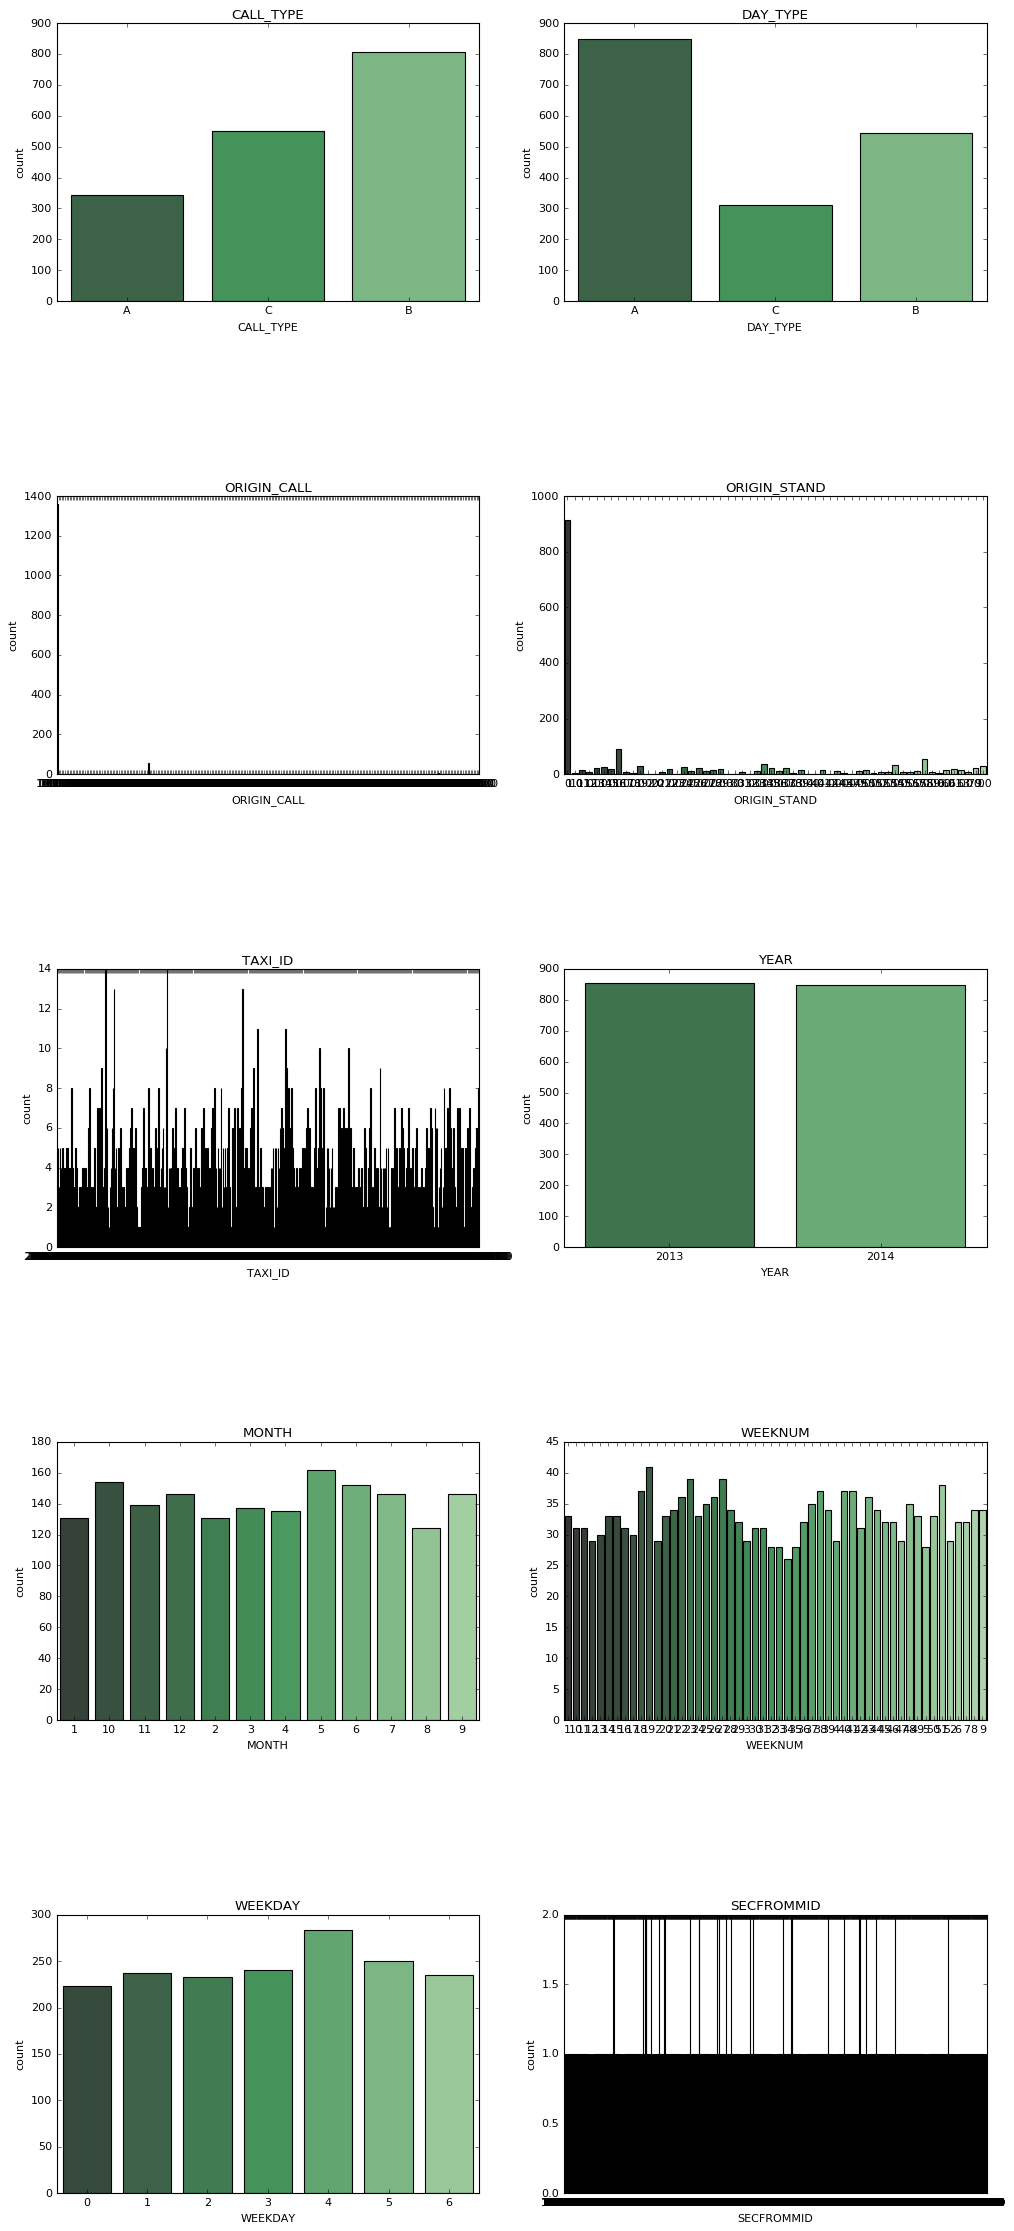

In [47]:
fig = plt.figure(figsize=(15,35))
cols = 2
rows = 5
columns = ['CALL_TYPE','DAY_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
           'YEAR', 'MONTH', 'WEEKNUM', 'WEEKDAY', 'SECFROMMID']

for i, column in enumerate(columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    sns.countplot(x=column, data=data_to_cluster, palette="Greens_d");
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#sns.countplot(x="CALL_TYPE", data=data_to_cluster, palette="Greens_d");

# Clusterization

In [3]:
def gower_distances(X, Y=None, w=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    Returns
    -------
    distances : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity for categorical, boolean and numerical mixed data.
    """

    X, Y = pairwise.check_pairwise_arrays(X, Y, dtype=np.object)
    
    rows, cols = X.shape
    dtypes = []
    for col in range(cols):
        dtypes.append(type(X[0, col]))

    # calculate the range and max values of numeric values for mixed data
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if np.issubdtype(dtypes[col], np.number):
            max = np.nanmax(X[:, col].astype(dtypes[col])) + 0.0
            if np.isnan(max):
                max = 0.0

            max_of_numeric[col] = max

            min = np.nanmin(X[:, col].astype(dtypes[col])) + 0.0
            if np.isnan(min):
                min = 0.0

            ranges_of_numeric[col] = (1 - min / max,0)[max == 0]


    # According the Gower formula, w is an attribute weight
    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)


    for i in range(0, rows ):
        j_start = i
        
        #for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            xi = X[i]
            xj = Y[j]
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = xi[col]
                value_xj = xj[col]
                if np.issubdtype(dtypes[col], np.number):
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0 :
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij=0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij
            
            if sum_wij!=0:
                dm[i,j] = (sum_sij / sum_wij)
                if j < rows and i<yrows :
                    dm[j,i] = dm[i,j]
                
            
            
    return dm

In [23]:
# try different clustering algorithms

# get distance matrix
gower_dist_matrix = gower_distances(data_to_cluster)

In [36]:
# Affinity propagation

labels = []
affinity_propagation = cluster.AffinityPropagation(damping=0.9, 
                                                   affinity='precomputed')

labels_aff = affinity_propagation.fit(1 - gower_dist_matrix)
labels.append(labels_aff.labels_.astype(np.int))

In [6]:
clust = []
for i in range(50,100):
    affinity_propagation = cluster.AffinityPropagation(damping=i/100., 
                                                   affinity='precomputed')

    labels = affinity_propagation.fit(gower_dist_matrix)
    labels.labels_.astype(np.int)
    
    clust.append(len(np.unique(labels)))

KeyboardInterrupt: 

In [37]:
#DBSCAN
dbscan = cluster.DBSCAN(eps=0.13,
                        min_samples = len(X_train_cluster)/32, 
                        metric='precomputed')

labels.append(dbscan.fit_predict(gower_dist_matrix) + 1)

In [28]:
clust = []
for i in range(1,100):
    dbscan = cluster.DBSCAN(eps=i/100.,
                        min_samples = len(X_train_cluster)/32, 
                        metric='precomputed')

    labels = dbscan.fit_predict(gower_dist_matrix)
    clust.append(len(np.unique(labels)))
    

In [38]:
# Spectral Clustering
# now i need to use different number of clusters

clusters = [112, 4]
delta = 1
aff_matrix = np.exp(- gower_dist_matrix ** 2 / (2. * delta ** 2))


for n_cluster in clusters:
    spectral = cluster.SpectralClustering(n_clusters=n_cluster, 
                                              affinity='precomputed')

    labels_spectral = spectral.fit(aff_matrix)
    labels.append(labels_spectral.labels_.astype(np.int))

In [39]:
# now let's evaluate perfomance

for label in labels:
    print metrics.silhouette_score(gower_dist_matrix, label, metric='precomputed')

0.0765779307997
0.0905371038442
0.0317115681906
0.311990523627


# This can used for stacking
## let's implement defferent clustering algorithms

In [7]:
X, y = data_processing_to_train(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 0)

In [6]:
scaler = preprocessing.StandardScaler()
columns_to_scale = ['Start_lon', 'Start_lon', 'SECFROMMID']
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

In [9]:
min_samples_leaf = len(X_train)/32

regr_multirf = MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=min_samples_leaf,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor( random_state=2)
regr_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [10]:
print traj_score(y_test, regr_multirf.predict(X_test))

print traj_score(y_test, regr_rf.predict(X_test))

18.2142500742
20.318420542


### Following methods can be used
* Knn Regressor (+Multi)
* RF (+Multi)
* SVM (+Multi)
* CART (+Multi)
* AdaBoost (+Multi)
* XgBoost (+Multi)


### kNN Regressor

We will test different type of data and metrics. To find optimal number of neighbours, it is needed to grid over different values. To save time, we will test performance of different data types and metrics and after find optimal number of nearest neighbours.

In [13]:
#standard data with std metric
clf = MultiOutputRegressor(KNeighborsRegressor(5))
clf.fit(X_train, y_train)
print traj_score(y_test, clf.predict(X_test))

#scaled data with std metric
clf.fit(X_train_scaled, y_train)
print traj_score(y_test, clf.predict(X_test_scaled))

#standard data with Jaccard metric
clf = MultiOutputRegressor(KNeighborsRegressor(5, metric="jaccard"))
clf.fit(X_train, y_train)
print traj_score(y_test, clf.predict(X_test))

#scaled data with Jaccard metric
clf.fit(X_train_scaled, y_train)
print traj_score(y_test, clf.predict(X_test_scaled))

22.9788154722
22.8289443974
23.3134053335
23.3134053335


In [14]:
#need to be launched

scoresK = []

for k in range(1,60):
    print k
    clf = MultiOutputRegressor(KNeighborsRegressor(k))
    clf.fit(X_train_scaled, y_train)
    scoresK.append(traj_score(y_test, clf.predict(X_test_scaled)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


The highest score is 19.6831462677 with 59 nearest neighbours


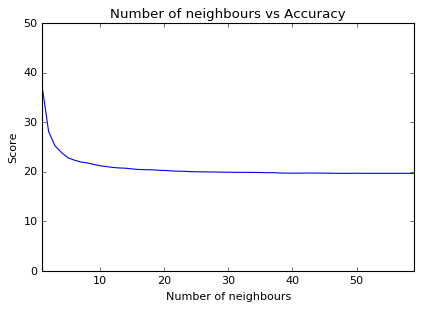

In [21]:
plt.plot(range(1,60), scoresK)
plt.axis([1, len(scoresK), 0, 50])
plt.ylabel('Score')
plt.xlabel('Number of neighbours')
plt.title('Number of neighbours vs Accuracy')

max_acc_knn = min(scoresK)
best_k_knn = scoresK.index(min(scoresK))+1
print 'The highest score is %s with %s nearest neighbours' % (max_acc_knn, best_k_knn)

In [11]:
kNN_clf = MultiOutputRegressor(KNeighborsRegressor(59))
kNN_clf.fit(X_train_scaled, y_train)
print traj_score(y_test, kNN_clf.predict(X_test_scaled))

19.6831462677


### Linear SVM

In [27]:
# 10000 iterations could be the best variant, because there are trad-off between accuracy and estimation time
clf = MultiOutputRegressor(svm.SVR(kernel='linear', max_iter = 10000, tol = 1e-2))
clf.fit(X_train, y_train)
print traj_score(y_test, clf.predict(X_test))

#scaled data with std metric
clf.fit(X_train_scaled, y_train)
print traj_score(y_test, clf.predict(X_test_scaled))

2.48181106709e+28
6.4317203978e+28


//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


### CART

In [34]:
clf1_ = MultiOutputRegressor(DecisionTreeRegressor(max_depth=1, random_state=0))
clf2_ = MultiOutputRegressor(DecisionTreeRegressor(max_depth=3, random_state=0))
clf3_ = MultiOutputRegressor(DecisionTreeRegressor(max_depth=7, random_state=0))
clf4_ = MultiOutputRegressor(DecisionTreeRegressor(max_depth=None, random_state=0))

clf1_.fit(X_train, y_train)
print traj_score(y_test, clf1_.predict(X_test))
clf2_.fit(X_train, y_train)
print traj_score(y_test, clf2_.predict(X_test))
clf3_.fit(X_train, y_train)
print traj_score(y_test, clf3_.predict(X_test))
clf4_.fit(X_train, y_train)
print traj_score(y_test, clf4_.predict(X_test))

19.1074644603
19.097774966
20.0115997396
30.7686001138


In [13]:
CART_clf = MultiOutputRegressor(DecisionTreeRegressor(max_depth=3, random_state=0, min_samples_leaf=min_samples_leaf))
CART_clf.fit(X_train, y_train)
print traj_score(y_test, CART_clf.predict(X_test))

18.2345812708


### Random Forest

In [35]:
clf1_ = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, max_depth=3, random_state=0))
clf2_ = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0))
clf3_ = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, max_depth=None, random_state=0))
clf4_ = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0))

clf1_.fit(X_train, y_train)
print traj_score(y_test, clf1_.predict(X_test))
clf2_.fit(X_train, y_train)
print traj_score(y_test, clf2_.predict(X_test))
clf3_.fit(X_train, y_train)
print traj_score(y_test, clf3_.predict(X_test))
clf4_.fit(X_train, y_train)
print traj_score(y_test, clf4_.predict(X_test))

18.6911110855
18.4483493172
20.30717964
19.374416034


In [12]:
RF_clf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0, min_samples_leaf=min_samples_leaf))
RF_clf.fit(X_train, y_train)
print traj_score(y_test, RF_clf.predict(X_test))

18.1697651787


### AdaBoost

In [41]:
clf1_ = MultiOutputRegressor(AdaBoostRegressor(n_estimators=10, 
                           base_estimator=(DecisionTreeRegressor(max_depth=1)), random_state=0))
clf2_ = MultiOutputRegressor(AdaBoostRegressor(n_estimators=100, 
                           base_estimator=(DecisionTreeRegressor(max_depth=1)), random_state=0))
clf3_ = MultiOutputRegressor(AdaBoostRegressor(n_estimators=10, 
                           base_estimator=(DecisionTreeRegressor(max_depth=3)), random_state=0))
clf4_ = MultiOutputRegressor(AdaBoostRegressor(n_estimators=100, 
                           base_estimator=(DecisionTreeRegressor(max_depth=3)), random_state=0))

clf1_.fit(X_train, y_train)
print traj_score(y_test, clf1_.predict(X_test))
clf2_.fit(X_train, y_train)
print traj_score(y_test, clf2_.predict(X_test))
clf3_.fit(X_train, y_train)
print traj_score(y_test, clf3_.predict(X_test))
clf4_.fit(X_train, y_train)
print traj_score(y_test, clf4_.predict(X_test))

19.4492194325
19.8388653661
19.3132009845
20.5915131363


In [16]:
Ada_clf = MultiOutputRegressor(AdaBoostRegressor(n_estimators=10, 
                                                 base_estimator=(DecisionTreeRegressor(max_depth=3)),
                                                 random_state=0,
                                                 learning_rate = 0.1))
Ada_clf.fit(X_train, y_train)
print traj_score(y_test, Ada_clf.predict(X_test))

18.6459230394


### XgBoost

In [44]:
score_xgbc = []
clf1_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=10, max_depth=1, learning_rate=0.1, seed=0))

clf2_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=1000, max_depth=1, learning_rate=0.1, seed=0))

clf3_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1, seed=0))

clf4_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, seed=0))

clf5_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=10, max_depth=1, learning_rate=0.5, seed=0))

clf6_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=1000, max_depth=1, learning_rate=0.5, seed=0))

clf7_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.5, seed=0))

clf8_ = MultiOutputRegressor(xg.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.5, seed=0))

clf1_.fit(X_train, y_train)
print traj_score(y_test, clf1_.predict(X_test))
clf2_.fit(X_train, y_train)
print traj_score(y_test, clf2_.predict(X_test))
clf3_.fit(X_train, y_train)
print traj_score(y_test, clf3_.predict(X_test))
clf4_.fit(X_train, y_train)
print traj_score(y_test, clf4_.predict(X_test))
clf5_.fit(X_train, y_train)
print traj_score(y_test, clf5_.predict(X_test))
clf6_.fit(X_train, y_train)
print traj_score(y_test, clf6_.predict(X_test))
clf7_.fit(X_train, y_train)
print traj_score(y_test, clf7_.predict(X_test))
clf8_.fit(X_train, y_train)
print traj_score(y_test, clf8_.predict(X_test))

2572393.46752
18.7016556094
2572393.46752
19.8294933032
38.6423681348


NotFittedError: This MultiOutputRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [45]:
clf6_.fit(X_train, y_train)
print traj_score(y_test, clf6_.predict(X_test))
clf7_.fit(X_train, y_train)
print traj_score(y_test, clf7_.predict(X_test))
clf8_.fit(X_train, y_train)
print traj_score(y_test, clf8_.predict(X_test))

19.4754217046
39.1471494523
23.0793961356


In [17]:
XG_clf = MultiOutputRegressor(xg.XGBRegressor(n_estimators=1000, max_depth=1, learning_rate=0.1, seed=0))
XG_clf.fit(X_train, y_train)
print traj_score(y_test, XG_clf.predict(X_test))

18.7016556094


### Try to upload to Kaggle

In [51]:
test_trajs = pd.read_csv('test.csv',
                        #index_col=,
                        #usecols = ['TRIP_ID', 'POLYLINE'],
                        converters={'POLYLINE': lambda x: json.loads(x)})

# add start_lat and start_lon to the dataset
traj = np.array(test_trajs['POLYLINE'])
test_trajs['Start_lon'] = [i[0][0] for i in traj]
test_trajs['Start_lat'] = [i[0][1] for i in traj]

# fill NA values as specific class
test_trajs = test_trajs.fillna('0')

# make some columns categorical (str)
cat_columns = ['CALL_TYPE','DAY_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID']
test_trajs[cat_columns] = test_trajs[cat_columns].astype(str)

# crate data for clusterization
submission = test_trajs['TRIP_ID']
test_trajs = test_trajs.drop(['MISSING_DATA', 'TRIP_ID', 'POLYLINE', 'DAY_TYPE'], 1)

# Work with timestamps

# get list of holidays in Portugal
pd_holidays = pd.read_csv('Portugal_holidays.csv')
holidays = [date(pd_holidays.Year[i], pd_holidays.Month[i], pd_holidays.Day[i]) for i in range(len(pd_holidays))]
del pd_holidays

# what i want to get?
# year, month, day, seconds from midnight, weeknumber, weekday

dates = []
for tmstmp in test_trajs['TIMESTAMP']:
    t = datetime.utcfromtimestamp(tmstmp)
    date_info = []
    date_info.append(t.year) # year
    date_info.append(t.month) # month
    date_info.append(t.isocalendar()[1]) # weeknumber
    date_info.append(t.weekday()) # weekday where Monday is 0 and Sunday is 6
    date_info.append((t.hour * 3600) + (t.minute * 60) + t.second + (t.microsecond / 1000000.0)) # seconds from midnight
    
    t_date = t.date()
    if t_date in holidays:
        date_info.append('B')
    elif (date_info[3] == 6) or (date_info[3] == 5):
        date_info.append('B')
    elif (t_date + timedelta(1)) in holidays:
        date_info.append('C')
    elif date_info[3] == 4:
        date_info.append('C')
    else:
        date_info.append('A')
    
    dates.append(date_info)

dates = np.array(dates)
dates_columns = ['YEAR', 'MONTH', 'WEEKNUM', 'WEEKDAY', 'SECFROMMID', 'DAY_TYPE']
dates_df = pd.DataFrame(data = dates, columns = dates_columns)

test_trajs = pd.concat([test_trajs, dates_df], axis=1)
test_trajs['SECFROMMID'] = test_trajs['SECFROMMID'].astype(float)

dummy_cols = ['CALL_TYPE','DAY_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 
              'MONTH', 'WEEKNUM', 'WEEKDAY']

test_trajs = pd.get_dummies(test_trajs, columns=dummy_cols)

drop_columns = ['CALL_TYPE_A', 'DAY_TYPE_A', 'ORIGIN_CALL_2002.0', 'ORIGIN_STAND_1.0', 'TAXI_ID_20000542',
                'MONTH_8', 'WEEKNUM_33', 'WEEKDAY_0']
test_trajs = test_trajs.drop(drop_columns,1)

In [45]:
zero_data = np.zeros((len(test_trajs), len(X.columns)))
df_test = pd.DataFrame(zero_data, columns = X.columns)

for col_name in test_trajs.columns:
    if col_name in df_test.columns:
        df_test[col_name] = test_trajs[col_name]

In [63]:
def submit(prediction, name, ids):
    arr = np.array(prediction)
    submission = pd.DataFrame(data = ids)
    submission['LATITUDE'] = np.array(arr[:,1])
    submission['LONGITUDE'] = np.array(arr[:,0])
    submission.to_csv(name+'.csv', index = False)

In [65]:
submit(kNN_clf.predict(df_test), 'test_submission_kNN', submission)
submit(CART_clf.predict(df_test), 'test_submission_CART', submission)
submit(RF_clf.predict(df_test), 'test_submission_RF', submission)
submit(Ada_clf.predict(df_test), 'test_submission_Ada', submission)
submit(XG_clf.predict(df_test), 'test_submission_XG', submission)